In this example we consider a process that is measure by methods: a noisy sensor and a manual measurements performed with a high precision. The process is formulated as
$$X_{t+1} = X_t + \mathcal{N}(0, 1)$$.
The manual measurements are performed perfectly, while the sensor measurements have a Gaussian noise with a standard deviation of 1. The values are collected at every time step, while manual measurements are more expensive and performed more rarely and irregularly. Let's create the data:

In [2]:
import numpy as np
import pandas as pd
from numpy.random import default_rng


def rng(seed=100): return default_rng(seed)


N = 40

time = np.arange(N)

epsilon = rng().normal(0, 1, N)

latent_process = np.cumsum(epsilon)

measure_error = np.array([1e-3, 1])

timesteps = pd.date_range("2018-01-01 00:00:00", tz='utc', periods=N, freq="H")

y = (latent_process.reshape(-1, 1) + rng().normal(0, measure_error, size=(N, len(measure_error)))).T.flatten()
df = pd.DataFrame(
    {
        'time': np.tile(timesteps, len(measure_error)),
        'measure': np.repeat(['manual', 'sensor'], N),
        'y': y
    })

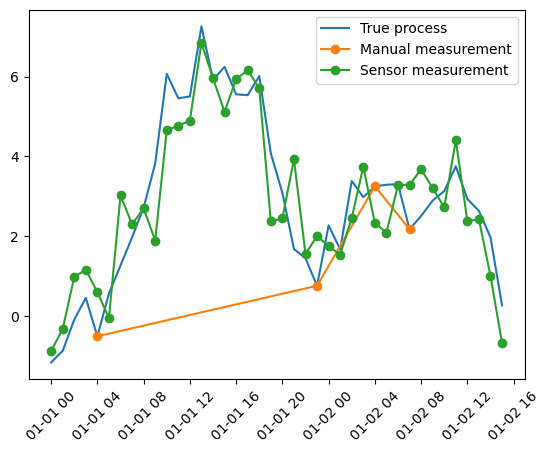

In [3]:
import matplotlib.pyplot as plt

df_0 = df.loc[df['measure'] == 'manual'].sample(frac=.1, random_state=rng()).sort_values(by='time')
df_1 = df.loc[df['measure'] == 'sensor']
experiment_df = pd.concat([df_0, df_1])

plt.plot(timesteps, latent_process, label='True process')
for k, sub in experiment_df.groupby(by='measure'):
    plt.plot(sub.time, sub['y'], '-o', label=str(k).capitalize() + ' measurement')

plt.xticks(rotation=45)
plt.legend()
plt.show()

Our model simply reflects the process, but to account for the varying noise of the measurements we use the `Concat` class to specify noise for each measurement type.

In [4]:
import pymc as pm
from sakkara.model.components import Distribution, Concat
from sakkara.model.utils import Likelihood, data_components, build

data = data_components(experiment_df)

x_sigma = Distribution(pm.Exponential, lam=Distribution(pm.Lognormal))

timesteps = df['time'].unique()


X = Concat(name='X', column='time')
X.add(timesteps[0], Distribution(pm.Normal, sigma=x_sigma))

for i in range(1, N):
    X.add(timesteps[i], Distribution(pm.Normal, mu=X[timesteps[i - 1]], sigma=x_sigma))

noise = Concat(name='noise',
               column='measure',
               components={
                   'manual': 1e-3,
                   'sensor': Distribution(pm.Exponential, lam=Distribution(pm.Lognormal)),
               }
               )

likelihood = Likelihood(pm.Normal, mu=X, sigma=noise, data=data['y'])

built_model = build(experiment_df, likelihood)
approx = pm.fit(100000, method='advi', model=built_model, random_seed=100)

Finished [100%]: Average Loss = 82.272


From this, we can get fairly well-calibrated predictions and uncertainties:

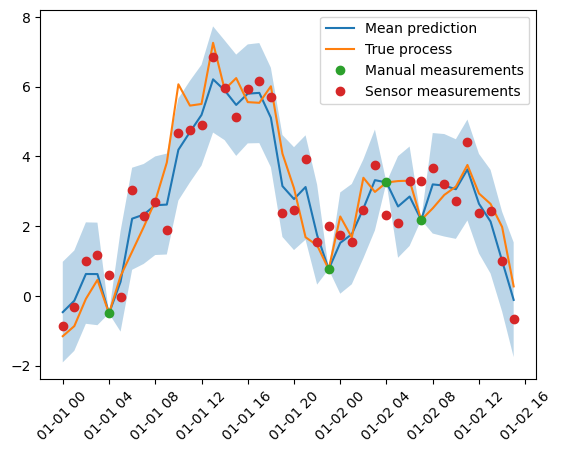

In [9]:
latent_posterior = approx.sample(10000).posterior[list(map(lambda i: f'{timesteps[i]}_X', range(N)))].to_dataframe()
plt.fill_between(timesteps, latent_posterior.quantile(.01), latent_posterior.quantile(.99), alpha=.3)
plt.plot(timesteps, latent_posterior.mean(), label='Mean prediction')

plt.plot(timesteps, latent_process, label='True process')
plt.plot(experiment_df.loc[experiment_df['measure'] == 'manual', 'time'],
         experiment_df.loc[experiment_df['measure'] == 'manual', 'y'], 'o', label='Manual measurements')
plt.plot(experiment_df.loc[experiment_df['measure'] == 'sensor', 'time'],
         experiment_df.loc[experiment_df['measure'] == 'sensor', 'y'], 'o', label='Sensor measurements')

plt.legend()
plt.xticks(rotation=45)
plt.show()